In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

In [39]:
data = fits.getdata('../data/Albireo_V_tenth_00{}.FIT'.format(1)).astype('i8')

In [37]:
dark_frames = [fits.getdata('../data/Albireo_V_tenth_dark00{}.FIT'.format(n)).astype('i8') for n in range(1,6)]
med_dark_frame = np.median(dark_frames, axis=0)

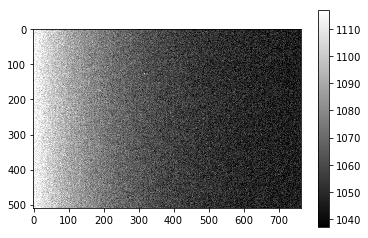

In [49]:
low, high = np.percentile(med_dark_frame.flatten(), [1, 99])
plt.imshow(med_dark_frame, cmap='gray', vmin=low, vmax=high)
plt.colorbar()

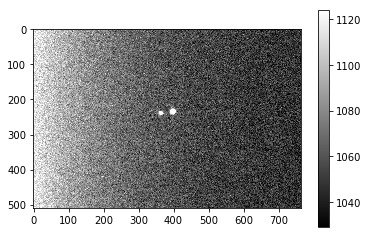

In [50]:
low, high = np.percentile(data.flatten(), [1, 99])
plt.imshow(data, cmap='gray', vmin=low, vmax=high)
plt.colorbar()

0.971232701199


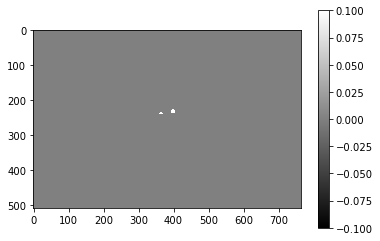

In [127]:
combined = data-med_dark_frame
bias = 0.
combined[combined < bias] = bias
combined = np.arcsinh(combined)
combined = combined/combined.max()
combined[combined < .6] = 0. 

from skimage import feature

peaks = feature.peak_local_max(combined, min_distance=4, threshold_abs=0.6)
print(35.3 / np.sqrt((peaks[0, 1] - peaks[1, 1])**2 + (peaks[0, 0]-peaks[1,0])**2))

low, high = np.percentile(combined, [.5,99.5])
plt.imshow(combined, cmap='gray', vmin=low, vmax=high)
# plt.plot(peaks[:, 1], peaks[:, 0], 'r.')
plt.colorbar()

In [86]:
print(peaks)

[[238 365]
 [233 401]]


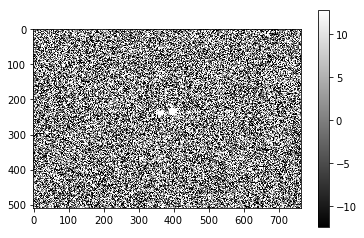

In [65]:
sinh = np.arcsinh(combined)
limg = sinh / sinh.mean()
low, upp = np.percentile(limg, [1, 99])
plt.imshow(combined, cmap='gray', vmin=low, vmax=upp)
plt.colorbar()

In [50]:


imgs = [fits.getdata('../data/raw_data/pipelineout/Albireo_V_tenth_00{}_out.FIT'.format(n)) for n in range(1, 11)]
bias = 0.

pixel_scale = []
fov = []
for img in imgs:
    img[img < bias] = bias
    peaks = feature.peak_local_max(img, min_distance=10, num_peaks=2)
    dalpha = 35.3
    pixel_scale.append(dalpha / np.linalg.norm(peaks[0] - peaks[1]))
    x, y = img.shape
    fov.append(y*dalpha / np.linalg.norm(peaks[0] - peaks[1]))
    
# Get interval
from scipy.stats import norm
mean = np.mean(pixel_scale)
alpha = 0.05
z = norm.ppf(1.0 - alpha/2)
s = np.std(pixel_scale)
n = len(pixel_scale)

print('Pixel Scale: {:.3f}+-{:.3f}'.format(mean, z*s/np.sqrt(n)))

mean = np.mean(fov)
alpha = 0.05
z = norm.ppf(1.0 - alpha/2)
s = np.std(fov)
n = len(fov)

print('Fov: {:.0f}+-{:.0f}'.format(mean, z*s/np.sqrt(n)))

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw_data/pipelineout/Albireo_V_tenth_001_out.FIT'

In [164]:
hdulist.close()

In [4]:
import scipy.stats
data = fits.getdata('../data/science/processed/Albireo_V_tenth_001_processed.FIT')

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(2)
gmm.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [14]:
np.mean(gmm.means_)

37.348411311719396

In [65]:
from photutils import DAOStarFinder  
from astropy.stats import sigma_clipped_stats
from glob import glob
import numpy as np
from astropy.io import fits


filenames = glob('../data/science/processed/*V*tenth*')
imgs = [fits.getdata(file) for file in filenames]

def get_sep(img):
    mean, median, std = sigma_clipped_stats(img, iters=5)
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)    
    sources = daofind(img)  
    positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
    return np.linalg.norm(positions[0]-positions[1])

seps = [get_sep(img) for img in imgs]


def get_pscale(seps, dalpha):
    pscales = dalpha / np.array(seps)
    pscale = np.mean(scales)
    pscale_std = np.std(scales)
    return pscale, std
    
pscale = get_pscale(seps, 35.3)    
x_len, y_len = imgs[0].T.shape


def get_fov(pscale, std, dalpha, leng):
    fov = leng * pscale
    std = leng * pscale**2 / dalpha * std
    return fov, std
    
    
fovx = get_fov(*pscale, 35.3, x_len)
fovy = get_fov(*pscale, 35.3, y_len)

print(pscale)
print(fovx)
print(fovy)


(1.0071920462512449, 0.0090617706963375001)
(770.50191538220236, 0.19921607219274567)
(513.6679435881349, 0.13281071479516379)


In [26]:
positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
distance = np.linalg.norm(positions[0]-positions[1])
print(distance)

35.2823719823


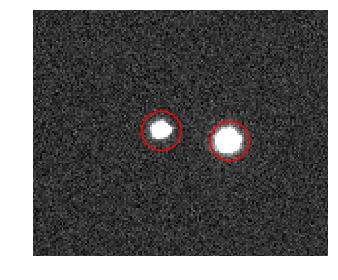

In [84]:
from photutils import CircularAperture
apertures = CircularAperture(positions, r=10)
plt.imshow(data, cmap='gray', origin='lower', vmin=-37, vmax=162)
apertures.plot(color='red', lw=1.5)
plt.xlim(300, 450)
plt.ylim(175, 300)
plt.axis('off')
plt.tight_layout()
plt.savefig('../docs/figs/dao.png')

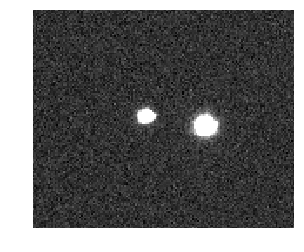

In [71]:



plt.imshow(data, cmap='gray', origin='lower', vmin=-37, vmax=162)
plt.xlim(300, 450)
plt.ylim(175, 300)
plt.axis('off')
plt.savefig('../docs/figs/v01.png')

In [110]:
low, high = -54, 240
filelist = glob('../data/science/processed/*V*full*')
imgs = np.array([fits.getdata(file) for file in filelist])

mean = np.mean(imgs)
median = np.median(imgs)
maxi = np.max(imgs)

print(maxi, mean, median)

64479.0 13.6906 6.0


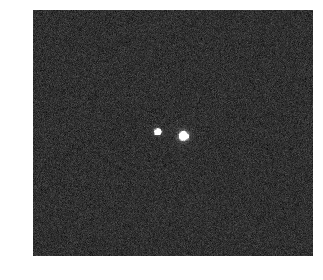

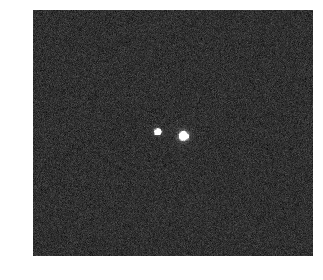

In [85]:
low, high = -54, 240
filelist = ['../data/science/processed/Albireo_V_half_001_processed.FIT', '../data/science/processed/Albireo_V_full_001_processed.FIT']
imgs = [fits.getdata(file) for file in filelist]

s = ['05', '10']
for i, img in enumerate(imgs):
    plt.figure()
    plt.imshow(data, cmap='gray', origin='lower', vmin=low, vmax=high)
    plt.xlim(200, 570)
    plt.ylim(75, 400)
    plt.axis('off')
    plt.tight_layout()
#     plt.savefig('../docs/figs/v{}.png'.format(s[i]))
